In [1]:
import tensorflow as tf
import numpy as np
import PIL
import glob
from IPython.display import clear_output, Image, display

np.set_printoptions(precision=2, suppress=True)


def display_array(a, rng=[0,255]):
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    display(PIL.Image.fromarray(a))

In [2]:
# Given a fen string and a rank (number) and file (letter), return label vector
def get_label(fen,rank,file):
    l2i = lambda l:  ord(l)-ord('A') # letter to index
    file = 8-file # FEN has order backwards
    piece_letter = fen[file*8 + file + l2i(rank)]
    #label = np.zeros(13, dtype=np.uint8)
    label = '1KQRBNPkqrbnp'.find(piece_letter)
    # note the 1 instead of ' ' due to FEN notation
    # We ignore shorter FENs with numbers > 1 because we generate the FENs ourselves
    return label


# Load Tiles with FEN string in filename for labels return both images and labels
def load_tiles(image_filepaths):
    # Each tile is a 32x32 grayscale image, add extra axis for working with MNIST Data format
    images = np.zeros([image_filepaths.size, 32, 32], dtype=np.uint8)
    labels = np.zeros([image_filepaths.size], dtype=np.uint8)

    for i, image_filepath in enumerate(image_filepaths):
        fen = image_filepath[-78:-7]
        rank = image_filepath[-6]
        file = int(image_filepath[-5]) 

        images[i,:,:] = np.asarray(PIL.Image.open(image_filepath), dtype=np.uint8)
        labels[i] = get_label(fen, rank, file)
    print("Done")
    return images, labels

In [3]:
# All tiles with pieces in random organizations
all_paths = np.array(glob.glob("train_tiles/*/*.png"))

# Shuffle order of paths so when we split the train/test sets the order of files doesn't affect it
np.random.shuffle(all_paths)

# split data into train/test

ratio = 0.9 # split ratio
divider = int(len(all_paths) * ratio)
train_paths = all_paths[:divider]
test_paths = all_paths[divider:]

print(f"Loading {train_paths.size} Training tiles")
train_images, train_labels = load_tiles(train_paths)

print(f"Loading {test_paths.size} Testing tiles")
test_images, test_labels = load_tiles(test_paths)

Loading 2649 Training tiles
Done
Loading 295 Testing tiles
Done


682: Piece(b)


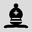

989: Piece(K)


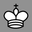

2017: Piece(r)


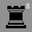

420: Piece(Q)


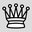

1692: Piece(K)


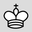

In [4]:
# Convert label index into name of piece
def labelIndex2Name(label_index):
    return ' KQRBNPkqrbnp'[label_index]


# Convert label vector into name of piece
def label2Name(label):
    return labelIndex2Name(label.argmax())


# check some of the labels
for i in np.random.choice(len(train_images), 5, replace=False):
    print(f"{i}: Piece({labelIndex2Name(train_labels[i])})")
    display_array(train_images[i,:,:])
    

In [5]:
# Normalize Images

train_norm_images = np.zeros([len(train_images), 32, 32], dtype=np.float64)
test_norm_images = np.zeros([len(test_images), 32, 32], dtype=np.float64)

for i in range(len(train_images)):
    train_norm_images[i,:,:] = train_images[i,:,:] / 255.0

for i in range(len(test_images)):
    test_norm_images[i,:,:] = test_images[i,:,:] / 255.0
    
print(train_norm_images[0,:,:])

[[0.86 0.86 0.86 ... 0.86 0.86 0.86]
 [0.86 0.86 0.86 ... 0.86 0.86 0.86]
 [0.86 0.86 0.86 ... 0.86 0.86 0.86]
 ...
 [0.86 0.86 0.86 ... 0.86 0.86 0.86]
 [0.86 0.86 0.86 ... 0.86 0.86 0.86]
 [0.86 0.86 0.86 ... 0.86 0.86 0.86]]


In [6]:
print(train_labels[0])

6


In [7]:
# Build our keras neural net
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(32, 32)),  
                                    tf.keras.layers.Dense(128, activation = tf.nn.relu),  
                                    tf.keras.layers.Dense(13, activation = tf.nn.softmax)])

model.compile(optimizer='adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics =['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1677      
Total params: 132,877
Trainable params: 132,877
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(train_norm_images, train_labels, epochs = 10) 

Epoch 1/10
83/83 [==============================] - 0s 2ms/step - loss: 2.1925 - accuracy: 0.5157
Epoch 2/10
83/83 [==============================] - 0s 2ms/step - loss: 1.8557 - accuracy: 0.8494
Epoch 3/10
83/83 [==============================] - 0s 1ms/step - loss: 1.8377 - accuracy: 0.8494
Epoch 4/10
83/83 [==============================] - 0s 1ms/step - loss: 1.8039 - accuracy: 0.8852
Epoch 5/10
83/83 [==============================] - 0s 1ms/step - loss: 1.7647 - accuracy: 0.9226
Epoch 6/10
83/83 [==============================] - 0s 3ms/step - loss: 1.7374 - accuracy: 0.9536
Epoch 7/10
83/83 [==============================] - 0s 3ms/step - loss: 1.6900 - accuracy: 1.0000
Epoch 8/10
83/83 [==============================] - 0s 2ms/step - loss: 1.6896 - accuracy: 1.0000
Epoch 9/10
83/83 [==============================] - 0s 2ms/step - loss: 1.6895 - accuracy: 1.0000
Epoch 10/10
83/83 [==============================] - 0s 2ms/step - loss: 1.6894 - accuracy: 1.0000


In [9]:
test_loss, test_acc = model.evaluate(test_norm_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)

10/10 - 0s - loss: 1.6894 - accuracy: 1.0000
Test accuracy: 1.0


In [11]:
model.save('models/softmax_v1')

INFO:tensorflow:Assets written to: models/softmax_v1/assets
